# Supervised Random Forest Analysis
This notebook demonstrates the use of a supervised Random Forest model for classification tasks. It includes data preprocessing, handling class imbalance, model training, cross-validation, and evaluation of performance metrics.

In [339]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, matthews_corrcoef, auc, average_precision_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Data Preprocessing
This section preprocesses the training and testing datasets by handling missing values and separating features from the target variable.

In [340]:
# Run the dataInfo notebook to preprocess the data
%run dataInfo.ipynb

# Combine diagnostic scores into a single feature
score_cols = [f"A{i}_Score" for i in range(1, 11)]
train_df['total_score'] = train_df[score_cols].sum(axis=1)
test_df['total_score'] = test_df[score_cols].sum(axis=1)

# Normalize the total score
train_df['score_ratio'] = train_df['total_score'] / 10
test_df['score_ratio'] = test_df['total_score'] / 10

# Add interaction features
train_df['gender_result'] = train_df['gender'] * train_df['result']
train_df['age_score_ratio'] = train_df['age'] * train_df['score_ratio']
train_df['score_autism'] = train_df['total_score'] * train_df['autism']
train_df['age_jaundice'] = train_df['age'] * train_df['jaundice']
train_df['autism_result'] = train_df['autism'] * train_df['result']
train_df['gender_total_score'] = train_df['gender'] * train_df['total_score']

test_df['gender_result'] = test_df['gender'] * test_df['result']
test_df['age_score_ratio'] = test_df['age'] * test_df['score_ratio']
test_df['score_autism'] = test_df['total_score'] * test_df['autism']
test_df['age_jaundice'] = test_df['age'] * test_df['jaundice']
test_df['autism_result'] = test_df['autism'] * test_df['result']
test_df['gender_total_score'] = test_df['gender'] * test_df['total_score']

# # Drop all columns that start with 'relation'
# train_df = train_df.loc[:, ~train_df.columns.str.startswith('relation')]
# test_df = test_df.loc[:, ~test_df.columns.str.startswith('relation')]

# Load the train and test datasets
cleanTrain = train_df.dropna()  # Drop missing values in training data
cleanTest = test_df.dropna()  # Drop missing values in test data


# Preprocess the train dataset
X = cleanTrain.drop(columns=['Class/ASD'])
y = cleanTrain['Class/ASD']



# Handle Class Imbalance and Define Model
This section applies SMOTE to address class imbalance and defines the Random Forest model with optimal parameters.

In [341]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
#X_resampled, y_resampled = smote.fit_resample(X, y)

# Define the Random Forest model with the best parameters
rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=40,
    class_weight='balanced',
    random_state=42
)


# Define stratified 10-fold CV with 3 repeats
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=12)


# Initialize Metrics
This section initializes lists to store evaluation metrics and aggregated precision-recall data.

In [342]:

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Initialize lists to store metrics
roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
mcc_scores = []

# Initialize lists to store aggregated precision and recall
all_precision = []
all_recall = []
PR_curve_list = []


X_train_main, X_holdout, y_train_main, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Cross-Validation and Model Training
This section performs stratified cross-validation, trains the model, and calculates evaluation metrics for each fold.

In [ ]:
for train_idx, val_idx in cv.split(X_train_main, y_train_main):
    # Split the original (unbalanced) data
    if isinstance(X, pd.DataFrame):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    else:
        X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Preprocessing
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Apply SMOTE only to training fold
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    rf_model.fit(X_resampled, y_resampled)

    # Make predictions
    y_val_pred = rf_model.predict(X_val)
    y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    pr_auc = np.trapz(recall, precision)
    f1 = f1_score(y_val, y_val_pred)
    mcc = matthews_corrcoef(y_val, y_val_pred)

    # Append metrics
    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
    f1_scores.append(f1)
    mcc_scores.append(mcc)
    all_precision.append(precision)
    all_recall.append(recall)
    PR_curve_list.append((precision, recall))


# Test Data Preprocessing and Predictions
This section preprocesses the test dataset, aligns it with the training data, and makes predictions using the trained model.

In [344]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Align test data columns with training data columns, excluding the target column
# Ensure X_resampled is a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train_main.columns[:X_resampled.shape[1]])

# Align test data columns with training data columns, excluding the target column
X_test = cleanTest[X_resampled_df.columns.intersection(cleanTest.columns)]
print(X_test)
X_test.to_csv('X_test.csv', index=False)
X_train_processed = imputer.fit_transform(X_resampled)
X_train_processed = scaler.fit_transform(X_train_processed)

X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

# Align test data columns with training data columns, excluding the target column
X_test = pd.DataFrame(X_test, columns=X_resampled_df.columns)

test_predictions = rf_model.predict(X_test)
test_probabilities = rf_model.predict_proba(X_test)[:, 1]

# 9. Add predictions to test set
cleanTest_with_predictions = cleanTest.copy()
cleanTest_with_predictions['Predicted_Class'] = test_predictions
cleanTest_with_predictions['Probability'] = test_probabilities


     A1_Score  A2_Score  ...  autism_result  gender_total_score
0           1         1  ...            0.0                   6
1           1         0  ...            0.0                   2
2           1         1  ...            0.0                   8
3           0         0  ...            0.0                   0
4           0         0  ...            0.0                   1
..        ...       ...  ...            ...                 ...
195         1         1  ...           -0.0                   6
196         1         0  ...            0.0                   2
197         1         0  ...            0.0                   4
198         0         1  ...            0.0                   0
199         1         0  ...            0.0                   0

[200 rows x 93 columns]


<Figure size 1000x600 with 0 Axes>

In [345]:

# Step 2: Fit preprocessing ONLY on training set
X_train_proc = imputer.fit_transform(X_train_main)
X_holdout_proc = imputer.transform(X_holdout)

X_train_proc = scaler.fit_transform(X_train_proc)
X_holdout_proc = scaler.transform(X_holdout_proc)

# Step 3: Apply SMOTE only to training data
X_resampled_final, y_resampled_final = smote.fit_resample(X_train_proc, y_train_main)


# Step 4: Train final model
rf_model.fit(X_resampled_final, y_resampled_final)

# Step 5: Predict on untouched holdout
y_holdout_pred = rf_model.predict(X_holdout_proc)
y_holdout_proba = rf_model.predict_proba(X_holdout_proc)[:, 1]

# Step 6: Compute metrics
final_roc_auc = roc_auc_score(y_holdout, y_holdout_proba)
final_pr_auc = average_precision_score(y_holdout, y_holdout_proba)
final_f1 = f1_score(y_holdout, y_holdout_pred)
final_mcc = matthews_corrcoef(y_holdout, y_holdout_pred)


# Aggregate Precision-Recall Curves and Calculate Metrics
This section aggregates precision-recall curves, calculates the area under the curve, and computes confidence intervals for evaluation metrics.

In [346]:
# Aggregate precision-recall curves
mean_precision = np.linspace(0, 1, 100)
mean_recall = np.zeros_like(mean_precision)

for precision, recall in zip(all_precision, all_recall):
    mean_recall += np.interp(mean_precision, np.flip(recall), np.flip(precision))
mean_recall /= len(all_precision)

# Calculate the area under the aggregated curve
pr_auc = auc(mean_precision, mean_recall)

# Calculate mean and confidence intervals for each metric
def calculate_ci(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    ci_lower = mean_score - 1.96 * std_score / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * std_score / np.sqrt(len(scores))
    return mean_score, ci_lower, ci_upper

mean_roc_auc, ci_lower_roc_auc, ci_upper_roc_auc = calculate_ci(roc_auc_scores)
mean_pr_auc, ci_lower_pr_auc, ci_upper_pr_auc = calculate_ci(pr_auc_scores)
mean_f1, ci_lower_f1, ci_upper_f1 = calculate_ci(f1_scores)
mean_mcc, ci_lower_mcc, ci_upper_mcc = calculate_ci(mcc_scores)

# Plot and Print Results
This section plots the precision-recall curves and prints the evaluation metrics with confidence intervals.


Final Model Performance on Holdout Set:
ROC-AUC: 0.8979
PR-AUC: 0.6086
F1 Score: 0.6765
Matthews Correlation Coefficient: 0.5912
Mean ROC-AUC: 0.9000231517249805 (95% CI: 0.8848356667613979, 0.9152106366885631)
Mean PR-AUC: 0.44843716378584525 (95% CI: 0.40985851465999024, 0.48701581291170026)
Mean F1 Score: 0.5852000257411484 (95% CI: 0.5469029457688328, 0.623497105713464)
Mean Matthews Correlation Coefficient: 0.5069435192806496 (95% CI: 0.46300952095467707, 0.5508775176066222)


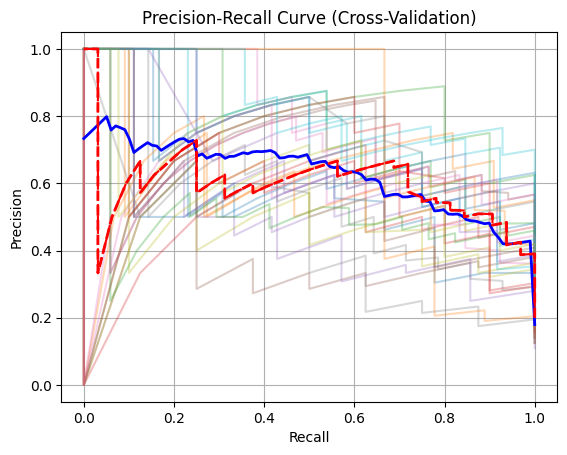

In [347]:
# Print results
for i, (precision, recall) in enumerate(PR_curve_list):
    plt.plot(recall, precision, alpha=0.3, label=f'Fold {i+1} PR Curve')
# Plot the aggregated curve
plt.plot(mean_precision, mean_recall, color='blue', lw=2, label=f'Average PR Curve (AUC = {pr_auc:.2f})')

final_precision, final_recall, _ = precision_recall_curve(y_holdout, y_holdout_proba)
final_avg_precision = average_precision_score(y_holdout, y_holdout_proba)

plt.plot(final_recall, final_precision, linestyle='--', color='red',
         label=f'Final Model PR (AUC={final_avg_precision:.2f})')

plt.plot(final_recall, final_precision, linestyle='--', color='red', lw=2,
         label=f'Final Model PR (AUC={final_avg_precision:.2f})')

# Add labels and legend
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

final_roc_auc = roc_auc_score(y_holdout, y_holdout_proba)
final_pr_auc = average_precision_score(y_holdout, y_holdout_proba)
final_f1 = f1_score(y_holdout, y_holdout_pred)
final_mcc = matthews_corrcoef(y_holdout, y_holdout_pred)

print("\nFinal Model Performance on Holdout Set:")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"PR-AUC: {final_pr_auc:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"Matthews Correlation Coefficient: {final_mcc:.4f}")

print(f"Mean ROC-AUC: {mean_roc_auc} (95% CI: {ci_lower_roc_auc}, {ci_upper_roc_auc})")
print(f"Mean PR-AUC: {mean_pr_auc} (95% CI: {ci_lower_pr_auc}, {ci_upper_pr_auc})")
print(f"Mean F1 Score: {mean_f1} (95% CI: {ci_lower_f1}, {ci_upper_f1})")
print(f"Mean Matthews Correlation Coefficient: {mean_mcc} (95% CI: {ci_lower_mcc}, {ci_upper_mcc})")